In [1]:
import gcm_filters
import xarray as xr
import xgcm
import matplotlib.pyplot as plt
import pathlib

In [2]:
DATAPATH = pathlib.Path("/lustre/data/shao/cug_2024/model_data")
FILTER_SCALE = 80*1e3 # Length of the features to coarsen to (km)

In [3]:
def calculate_slope(ds, grid_xgcm):
  """Calculate the magnitude of the isopycnal slope

  The magnitude of the isopycnal slope, correlated to the amount of energy available
  for turbulence to develop, is calculated from the gradient of the height of the
  interface zi=1 (the interface between the two layers). First the derivative of e
  in each direction is calculated, interpolated to the T point, squared, and then
  summed
  """

  e = ds.isel(zi=1).e.squeeze()
  slope_x = grid_xgcm.diff(e, "X")/grid_ds.dxT[0,0]
  slope_x = grid_xgcm.interp(slope_x, "X", to="center")
  slope_y = grid_xgcm.diff(e, "Y", boundary="extend")/grid_ds.dyT[0,0]
  slope_y = grid_xgcm.interp(slope_y, "Y", boundary="extend", to="center")
  return xr.ufuncs.sqrt(slope_x**2 + slope_y**2)

def interpolate_RV_to_T(ds, grid_xgcm):
  """Interpolate relative vorticity from the corner point to the cell enter
  """
  t = grid_xgcm.interp(ds.RV, "X", to="center")
  t = grid_xgcm.interp(t, "Y", to="center", boundary="extend")
  return t

def vertically_sum(da, h):
  """Vertically sum a quantity at the T-point
  """
  return (da*h).sum("zl")

def vertically_average(da, h):
  """Vertically average a quantity at the T-point
  """
  return vertically_sum(da, h)/h.sum("zl")


In [4]:
grid_ds = xr.open_dataset(DATAPATH / "ocean_geometry.nc") # Information about the grid, e.g. measures/coordinates of cells
raw_ds = xr.open_dataset(DATAPATH / "training_data.nc") # The raw data from the simulation to be transformed into features
# low_ds = xr.open_dataset("./training_data_low.nc")

In [5]:
# Calculate derived features
grid_xgcm = xgcm.Grid(raw_ds, periodic="X", coords={
      'X': {'center': 'xh', 'outer': 'xq'},
      'Y': {'center': 'yh', 'outer': 'yq'},
      'Z': {'inner': 'zl', 'outer': 'zi'}
    }
)
raw_ds["slope"] = calculate_slope(raw_ds, grid_xgcm)
raw_ds["RV_t"] = interpolate_RV_to_T(raw_ds, grid_xgcm)

# Vertically average/sum
raw_ds["slope_vert_avg"] = vertically_average(raw_ds.slope, raw_ds.h)
raw_ds["KE_vert_sum"] = vertically_sum(raw_ds.KE, raw_ds.h)
raw_ds["RV_vert_avg"] = vertically_sum(raw_ds.RV_t, raw_ds.h)

# Scale the Rd_dx variable based on the target grid spacing
grid_length = min(float(grid_ds.dxT.mean()), float(grid_ds.dxT.mean()))



/home/shao/.pyenv/versions/3.10.16/envs/cug-env-310/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [6]:
# Create a filter to mimic the variables from the coarse resolution
filter= gcm_filters.Filter(
    filter_scale=FILTER_SCALE,
    dx_min=float(grid_ds.dxT.min()),
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.REGULAR,
)


In [7]:
# Filter variables, note Rd_dx is omitted since it just needs to be scaled
train_ds = xr.Dataset(coords=raw_ds.coords, attrs=raw_ds.attrs)
for var in ["KE_vert_sum", "RV_vert_avg", "slope_vert_avg"]:
  train_ds[var] = filter.apply(raw_ds[var], dims=["yh", "xh"])

train_ds["Rd_dx_scaled"] = raw_ds["Rd_dx"]*grid_length/FILTER_SCALE


In [8]:
# Finally, calculate EKE itself (the predictor)
MKE = train_ds["KE_vert_sum"].mean("Time")
MKE.to_netcdf(DATAPATH/"MKE.nc")

train_ds["EKE"] = raw_ds["KE_vert_sum"] - train_ds["KE_vert_sum"].mean("Time")
train_ds["EKE"] = train_ds.EKE.where(train_ds.EKE>0, 0.)

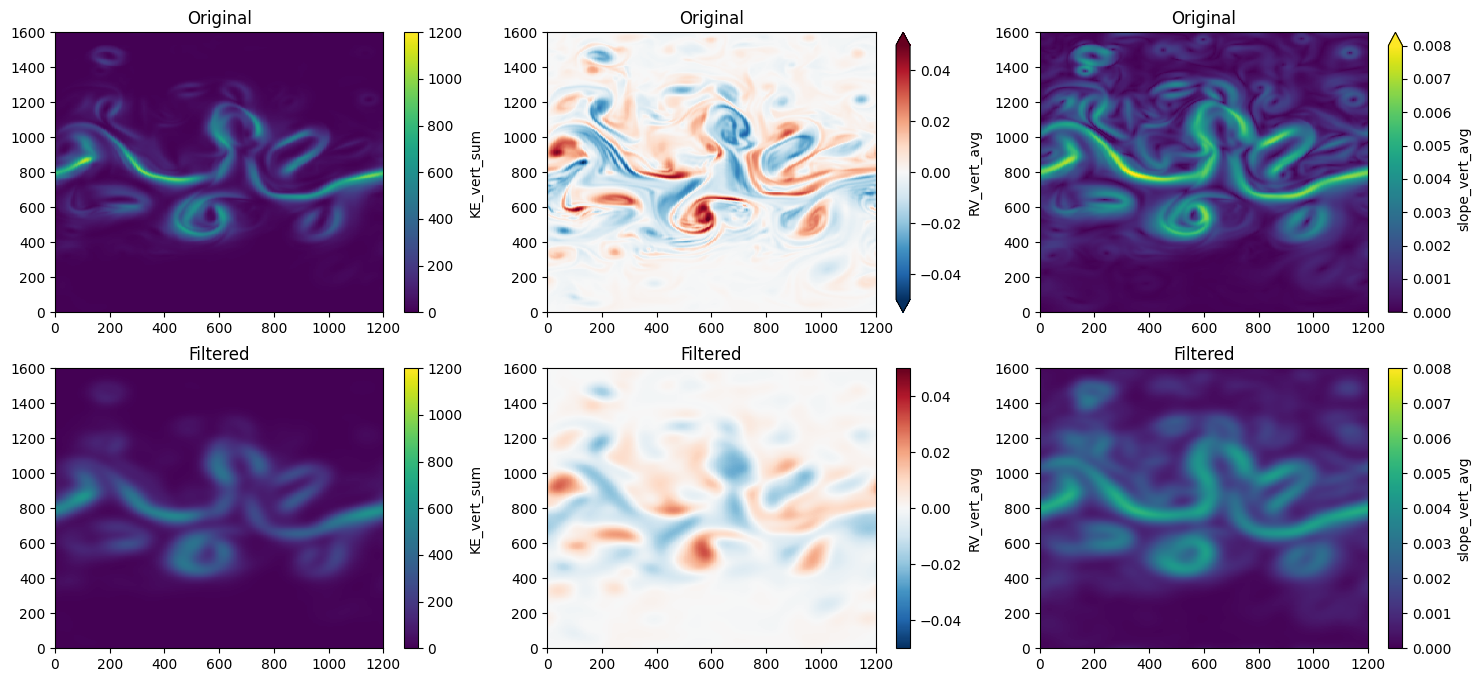

In [12]:
fig, axs = plt.subplots(2,3, figsize=(18,8))

plot_args = {
  "KE_vert_sum": {"vmin": 0, "vmax": 1200},
  "RV_vert_avg": {"vmin": -0.05, "vmax": 0.05, "cmap": plt.cm.RdBu_r},
  "slope_vert_avg": {"vmin": 0, "vmax": 0.008},
}


for i, var in enumerate(["KE_vert_sum", "RV_vert_avg", "slope_vert_avg"]):
  raw_ds[var].isel(Time=0).plot(ax=axs[0,i], **plot_args[var])
  axs[0,i].set_title("Original"); axs[0,i].set_xlabel(""); axs[0,i].set_ylabel("");
  train_ds[var].isel(Time=0).plot(ax=axs[1,i], **plot_args[var])
  axs[1,i].set_title("Filtered"); axs[1,i].set_xlabel(""); axs[1,i].set_ylabel("");

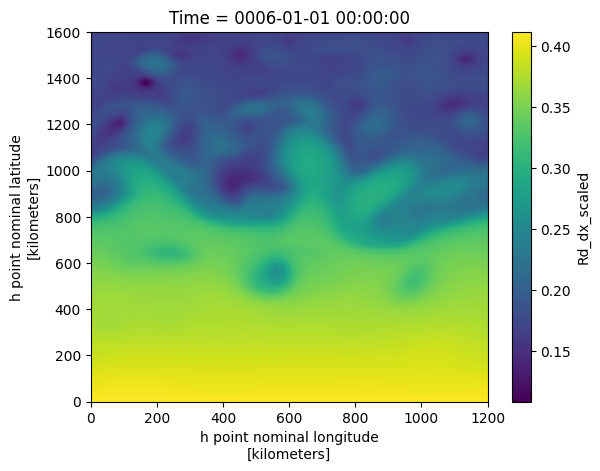

In [14]:
train_ds["Rd_dx_scaled"].isel(Time=0).plot()

/home/shao/.pyenv/versions/3.11.11/envs/cug-env/lib/python3.11/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


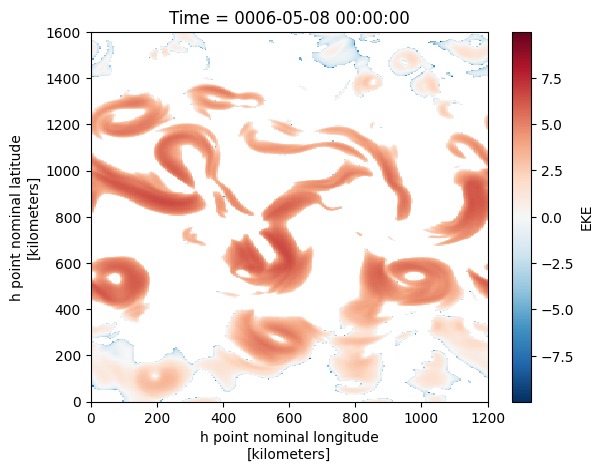

In [13]:
xr.ufuncs.log(train_ds.EKE.isel(Time=127)).plot()

In [17]:
train_ds.to_netcdf("featurized.nc")

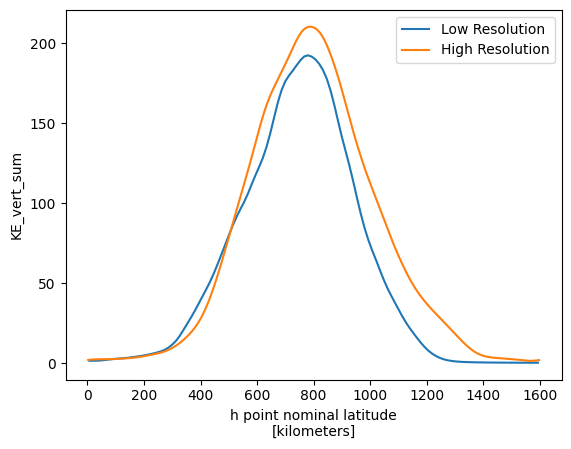

In [25]:

KE_low = vertically_sum(low_ds.KE, low_ds.h)
KE_low.mean(["Time", "xh"]).plot(label = "Low Resolution")
train_ds.KE_vert_sum.mean(["Time", "xh"]).plot(label="High Resolution")
plt.legend()

In [15]:
grid_length

5000.0